# Lab04 CNN from Pytorch

In [22]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


# Step 0: Show Data

In [24]:
# https://www.kaggle.com/code/pyim59/starter-mnist-in-csv-5b700bc9-3

In [25]:
print("Folder contains：")
print(os.listdir("./MNIST_revise"))

Folder contains：
['mnist_test.csv', 'mnist_train.csv']


In [26]:
file_path = []
for dirname, _, filenames in os.walk('./MNIST_revise'):
    for filename in filenames:
        file_path.append(str(filename))
        print(os.path.join(dirname, filename))

./MNIST_revise/mnist_test.csv
./MNIST_revise/mnist_train.csv


In [27]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# mnist_test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('./MNIST_revise/mnist_test.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'mnist_test.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 785 columns


In [28]:
df1.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Show 10 imgs (from mnist_test.csv)

(784,)
(28, 28)


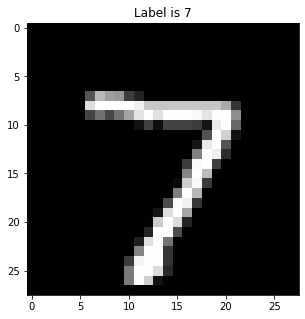

(784,)
(28, 28)


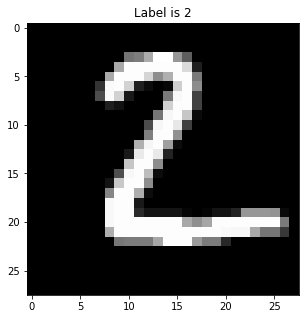

(784,)
(28, 28)


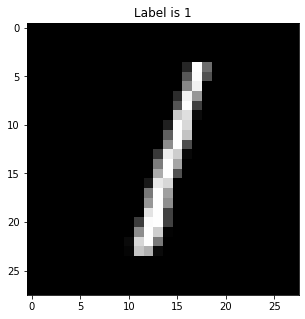

(784,)
(28, 28)


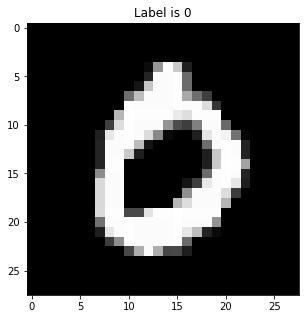

(784,)
(28, 28)


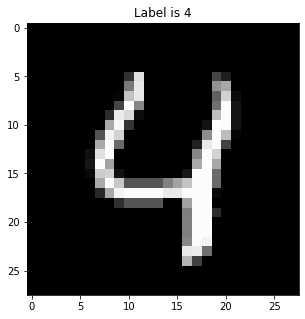

(784,)
(28, 28)


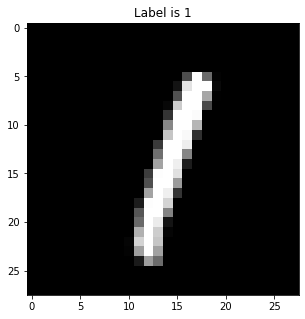

(784,)
(28, 28)


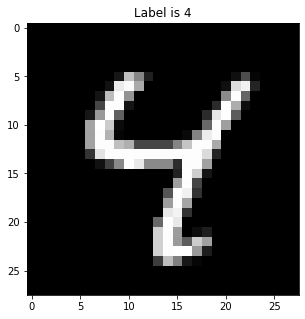

(784,)
(28, 28)


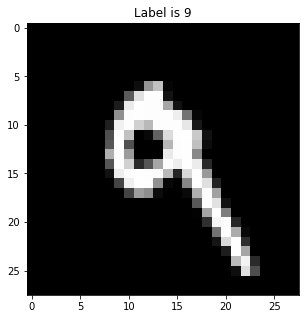

(784,)
(28, 28)


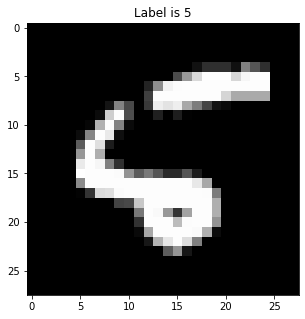

(784,)
(28, 28)


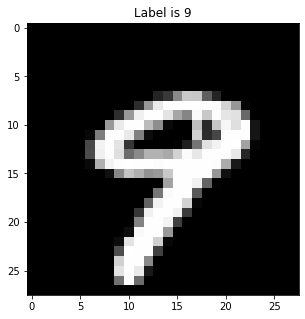

In [29]:
cnt = 0

with open('./MNIST_revise/mnist_test.csv', 'r') as csv_file:
    csvreader = csv.reader(csv_file)
    next(csvreader)
    for data in csvreader:
        
        # The first column is the label
        label = data[0]

        # The rest of columns are pixels
        pixels = data[1:]

        # Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(pixels, dtype = 'int64')
        print(pixels.shape)
        # Reshape the array into 28 x 28 array (2-dimensional array)
        pixels = pixels.reshape((28, 28))
        print(pixels.shape)
        # Plot
        plt.title('Label is {label}'.format(label=label))
        plt.imshow(pixels, cmap='gray')
        plt.show()
        
        cnt += 1
        if cnt == 10:
            break

# Step 2: Load Data

In [30]:
train = pd.read_csv("./MNIST_revise/mnist_train.csv")
test  = pd.read_csv("./MNIST_revise/mnist_test.csv")

In [31]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
X_train = train.drop(labels = ["label"],axis = 1)
Y_train = train["label"]

X_test = test.drop(labels = ["label"],axis = 1)
Y_test = test["label"]


print("Info of training dataset：")
print('# of training samples: {}, Shape: {}'.format(len(train), train.shape))
print('# of training pixels : {}, Shape: {}'.format(len(X_train), X_train.shape))
print('# of classes : {}'.format(len(set(train["label"]))))
print('shape of labels : {}, Shape: {}\n'.format(len(Y_train), Y_train.shape))

print("Info of validation dataset：")
print('# of training samples: {}, Shape: {}'.format(len(test), test.shape))
print('# of training pixels : {}, Shape: {}'.format(len(X_test), X_test.shape))
print('shape of label : {}, Shape: {}'.format(len(Y_test), Y_test.shape))

Info of training dataset：
# of training samples: 60000, Shape: (60000, 785)
# of training pixels : 60000, Shape: (60000, 784)
# of classes : 10
shape of labels : 60000, Shape: (60000,)

Info of validation dataset：
# of training samples: 10000, Shape: (10000, 785)
# of training pixels : 10000, Shape: (10000, 784)
shape of label : 10000, Shape: (10000,)


In [34]:
X_train

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
Y_train

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: label, Length: 60000, dtype: int64

In [36]:
train['label'].value_counts().index

Int64Index([1, 7, 3, 2, 9, 0, 6, 8, 4, 5], dtype='int64')

In [37]:
train['label'].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

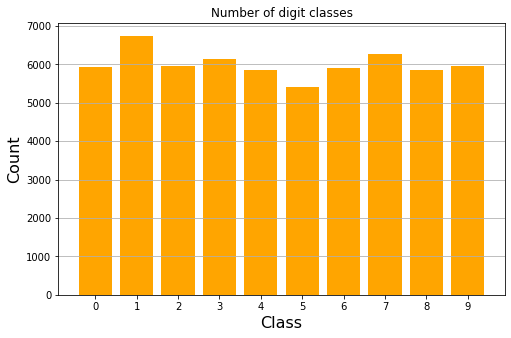

In [38]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train['label'].value_counts().index, train['label'].value_counts(), color = 'orange')
plt.xticks(np.arange(len(set(train["label"]))))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title("Number of digit classes")
plt.grid('on', axis='y')

## Normalize

In [39]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Split data

In [40]:
random_state = np.random.randint(200)
img_train, img_val, target_train, target_val = train_test_split(
    X_train, Y_train, test_size = 0.2, random_state = random_state
)

In [41]:
xTrain = torch.from_numpy(img_train.values)
yTrain = torch.from_numpy(target_train.values).type(torch.LongTensor) 
xVal = torch.from_numpy(img_val.values)
yVal = torch.from_numpy(target_val.values).type(torch.LongTensor) 
xTest = torch.from_numpy(X_test.values)
yTest = torch.from_numpy(Y_test.values).type(torch.LongTensor) 

# Pytorch train and test TensorDataset
train = torch.utils.data.TensorDataset(xTrain, yTrain)
val = torch.utils.data.TensorDataset(xVal, yVal)
test = torch.utils.data.TensorDataset(xTest, yTest)

# Step 3: Build Model

## Hyper Parameters

In [42]:
# Hyper Parameters
learning_rate = 0.001
batch_size = 600
n_iters = 10000

num_epochs = int(n_iters / (len(img_train) / batch_size) )

## DataLoader

In [43]:
# DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

## Model

In [44]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # input_shape=(1,28,28)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) #output_shape=(16,26,26)
        self.batchnormalize1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,13,13)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2) #output_shape=(32,16,16)
        self.batchnormalize2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU() 
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #output_shape=(32,8,8)
        
        # Fully connected  ,#input_shape=(32*8*8)
        self.fc1 = nn.Linear(32 * 8 * 8, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.batchnormalize1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Convolution 2
        out = self.cnn2(out)
        out = self.batchnormalize2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        
        # Linear function (readout)
        out = self.fc1(out)
        return out

In [45]:
model1 = Model().cuda()
print(model1)

Model(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnormalize1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchnormalize2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)


In [46]:
# # https://clay-atlas.com/blog/2020/04/26/pytorch-cn-note-use-torchsummary-visualization-model/

## Summary

In [47]:
from torchsummary import summary

summary(model1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 25,386
Trainable params: 25,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.10
Estimated Total Size (MB): 0.61
---------------------------------------------

In [48]:
model = Model()

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # https://blog.csdn.net/KGzhang/article/details/77479737
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted
input_shape = (-1, 1, 28, 28)

In [50]:
def train_model(model, loss_func, optimizer, input_shape, epoch, num_epochs, train_loader):
    training_loss = []
    training_accuracy = []
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(input_shape))
        labels = Variable(labels)
            
        optimizer.zero_grad() # Clear gradients
        outputs = model(train)
        train_loss = loss_func(outputs, labels) # Calculate softmax and cross entropy loss

        train_loss.backward() # Calculate gradients
        optimizer.step()      # Update parameters
            
        # torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)
        predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
        total_train += len(labels) # Total number of labels
        correct_train += (predicted == labels).float().sum() # Total correct predictions   
        
    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss.data)
    print('Epoch: [{}/{}]'.format(epoch+1, num_epochs))
    print(' Train --> Loss: {} Acc: {:.6f}% '.format(train_loss.data, train_accuracy))

    return training_loss, training_accuracy

In [51]:
def evaluate(model, loss_func, input_shape, val_loader, test_loader, mode):
    loss = []
    accuracy = []  
    
    if mode == 'validation':
        correct_val = 0
        total_val = 0
        for images, labels in val_loader:
            
            val = Variable(images.view(input_shape))
            outputs = model(val)

            val_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]

            total_val += len(labels)

            correct_val += (predicted == labels).float().sum()
            
        val_accuracy = 100 * correct_val / float(total_val)
        accuracy.append(val_accuracy)
        loss.append(val_loss.data)
        print(' Val   --> Loss: {} Acc: {:.6f}%'.format(val_loss.data, val_accuracy))
        return loss, accuracy, _

    elif mode == 'testing':
        correct_test = 0
        total_test = 0
        conf_matrix = np.zeros((10, 10))
        class_correct = [0]*10
        class_total   = [0]*10
        
        for images, labels in test_loader:
            test = Variable(images.view(input_shape))
            outputs = model(test)
            test_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]

            total_test += len(labels)
            correct_test += (predicted == labels).float().sum()         
            
            correct_tensor = predicted.eq(labels.data.view_as(predicted)) # compare, return Tensor(True, True,....)
            correct = np.squeeze(correct_tensor.numpy()) # return (True, True,....)
        
            for i in range(labels.size(0)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
                # Update confusion matrix
                conf_matrix[label][predicted.data[i]] += 1
        
        test_accuracy = 100 * correct_test / float(total_test)
        accuracy.append(test_accuracy)
        loss.append(test_loss.data)
        print(' Test result --> Loss: {} Acc: {:.6f}%'.format(test_loss.data, test_accuracy))
        
        print('Accuracy of each digits')
        for i in range(10):
            if class_total[i] > 0:
                print('Test Accuracy of {}: {}, [{}/{}]' .format(
                    i, 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i]))
                     )
            else:
                print('Test Accuracy of {}: N/A (no training examples)' .format(classes[i]))

        return loss, accuracy, conf_matrix
    else:
        print("Out of mode!")
        return None

In [52]:
def fit(model, loss_func, optimizer, input_shape, num_epochs, train_loader, val_loader, test_loader):    
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    for epoch in range(num_epochs):
        
        train_loss_per_epoch, training_accur_per_epoch = train_model(
            model, loss_func, optimizer, input_shape, epoch,  num_epochs, train_loader
        )
        training_loss.append(train_loss_per_epoch)
        training_accuracy.append(training_accur_per_epoch)
        
        mode = 'validation'
        val_loss_per_epoch, val_accur_per_epoch,_ = evaluate(
            model, loss_func, input_shape, val_loader, test_loader, mode
        )
        validation_loss.append(val_loss_per_epoch)
        validation_accuracy.append(val_accur_per_epoch)
    
    print("Now TESTING!!")
    mode = 'testing'
    print(" Mode：", mode)
    test_loss, test_accur, conf_matrix = evaluate(
            model, loss_func, input_shape, val_loader, test_loader, mode
        )
          
    return training_loss, training_accuracy, validation_loss, validation_accuracy, test_loss, test_accur, conf_matrix

# Step4: Train Model

In [53]:
training_loss, training_accuracy, validation_loss, validation_accuracy, test_loss, test_accur, conf_matrix = fit(
    model, loss_func, optimizer, input_shape, num_epochs, train_loader, val_loader, test_loader
)

Epoch: [1/125]
 Train --> Loss: 0.10008823126554489 Acc: 88.783333% 
 Val   --> Loss: 0.16177581250667572 Acc: 96.400002%
Epoch: [2/125]
 Train --> Loss: 0.06822112202644348 Acc: 97.152084% 
 Val   --> Loss: 0.06838776916265488 Acc: 97.741669%
Epoch: [3/125]
 Train --> Loss: 0.06130927428603172 Acc: 97.995834% 
 Val   --> Loss: 0.06709440797567368 Acc: 98.033333%
Epoch: [4/125]
 Train --> Loss: 0.04750137776136398 Acc: 98.437500% 
 Val   --> Loss: 0.04604965075850487 Acc: 98.391670%
Epoch: [5/125]
 Train --> Loss: 0.042151425033807755 Acc: 98.729164% 
 Val   --> Loss: 0.037997763603925705 Acc: 98.550003%
Epoch: [6/125]
 Train --> Loss: 0.02566082403063774 Acc: 98.908333% 
 Val   --> Loss: 0.054346732795238495 Acc: 98.658333%
Epoch: [7/125]
 Train --> Loss: 0.032994288951158524 Acc: 99.037498% 
 Val   --> Loss: 0.033031512051820755 Acc: 98.591667%
Epoch: [8/125]
 Train --> Loss: 0.022563375532627106 Acc: 99.141670% 
 Val   --> Loss: 0.03843516856431961 Acc: 98.775002%
Epoch: [9/125]
 Tr

 Val   --> Loss: 0.09325631707906723 Acc: 98.891670%
Epoch: [67/125]
 Train --> Loss: 0.00021832600759807974 Acc: 100.000000% 
 Val   --> Loss: 0.03702177479863167 Acc: 98.891670%
Epoch: [68/125]
 Train --> Loss: 0.0001902866060845554 Acc: 100.000000% 
 Val   --> Loss: 0.06298843026161194 Acc: 98.858330%
Epoch: [69/125]
 Train --> Loss: 0.00011513888603076339 Acc: 100.000000% 
 Val   --> Loss: 0.11377948522567749 Acc: 98.849998%
Epoch: [70/125]
 Train --> Loss: 0.00020348874386399984 Acc: 100.000000% 
 Val   --> Loss: 0.0930265262722969 Acc: 98.841667%
Epoch: [71/125]
 Train --> Loss: 0.00010813083645189181 Acc: 100.000000% 
 Val   --> Loss: 0.05127948895096779 Acc: 98.808334%
Epoch: [72/125]
 Train --> Loss: 0.00013171928003430367 Acc: 100.000000% 
 Val   --> Loss: 0.02543654665350914 Acc: 98.891670%
Epoch: [73/125]
 Train --> Loss: 0.00013425498036667705 Acc: 100.000000% 
 Val   --> Loss: 0.08961526304483414 Acc: 98.900002%
Epoch: [74/125]
 Train --> Loss: 0.00014312894199974835 Acc:

## Loss & Accuracy

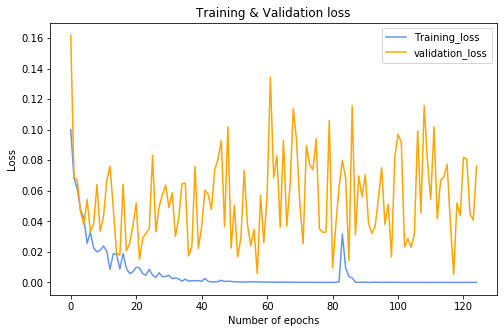

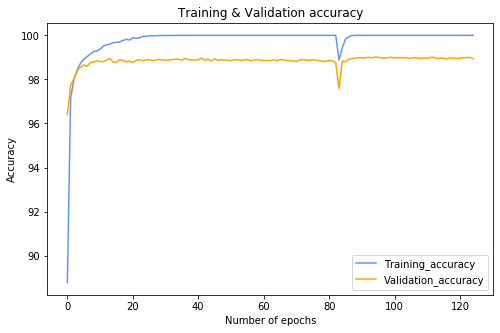

In [54]:
# visualization
plt.plot(training_loss, color='cornflowerblue', label='Training_loss')
plt.plot(validation_loss, color='orange', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(training_accuracy, color='cornflowerblue', label='Training_accuracy')
plt.plot(validation_accuracy, color='orange', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference

In [55]:
def inference(model, loss_func, input_shape, data_loader):
    loss = []
    accuracy = []  
    correct_val = 0
    total_val = 0
    
    fig = plt.figure(figsize=(15,10))
    
    cnt = 0
    
    for images, labels in data_loader:
        if cnt < 16:
            val = Variable(images.view(input_shape))
            outputs = model(val)

            val_loss = loss_func(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]

            total_val += len(labels)

            correct_val += (predicted == labels).float().sum()
            
            ax = fig.add_subplot(4, 8, cnt+1)
            ax.imshow(images[cnt].resize(28,28), cmap='gray')

            ax.set_title('y: {y}/ y_pred: {y_hat}'.format(y=labels[cnt], y_hat=predicted[cnt]))
            plt.axis('off')
            cnt += 1 
            
        else:
            break

    val_accuracy = 100 * correct_val / float(total_val)
    accuracy.append(val_accuracy)
    loss.append(val_loss.data)
    print('Loss: {} Acc: {:.6f}%'.format(val_loss.data, val_accuracy))
    
    
    return loss, accuracy



#          pixels = np.array(pixels, dtype = 'int64')
#         print(pixels.shape)
#         # Reshape the array into 28 x 28 array (2-dimensional array)
#         pixels = pixels.reshape((28, 28))
#         print(pixels.shape)
#         # Plot
#         plt.title('Label is {label}'.format(label=label))
#         plt.imshow(pixels, cmap='gray')

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:362: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Loss: 0.06581651419401169 Acc: 98.927086%


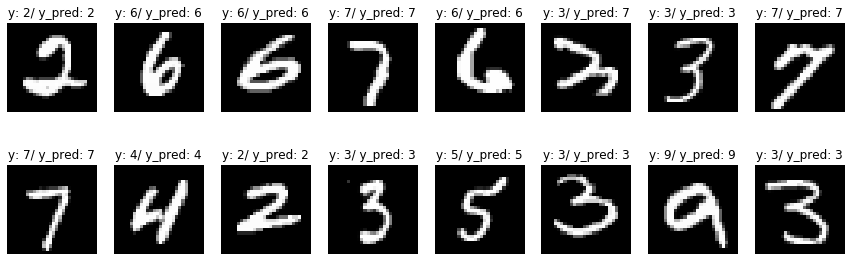

In [56]:
loss, accuraccy = inference(model, loss_func, input_shape, test_loader)

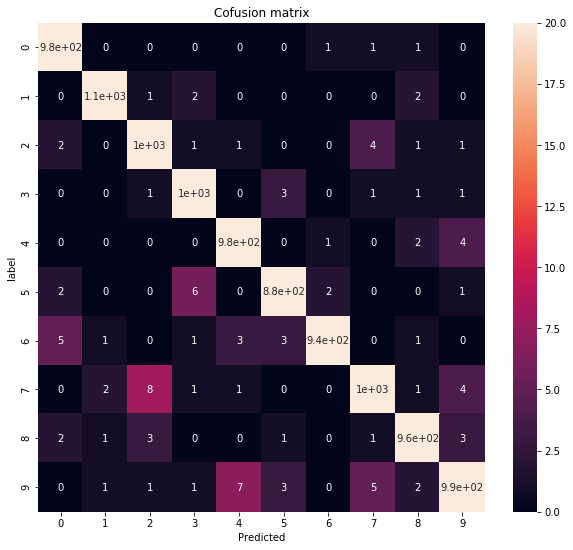

In [57]:
import seaborn as sns
plt.subplots(figsize=(10, 9))
plt.title('Cofusion matrix')
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted');
ax.set_ylabel('label');

In [ ]:
# def to_tensor(data):
#     return [torch.FloatTensor(point) for point in data]

# class MNISTData(Dataset):
#     def __init__(self, df, X_col, Y_col=None):
#         """
#         We're divding the values by 255 to normalize the dataset. 
#         It speeds up training. Why 255? because that's the maximum value for a pixel
#         """
        
#         self.features = df[X_col].values / 255
#         self.features = self.features.reshape(len(self.features), 1, 28, 28)
#         self.targets = df[Y_col].values.reshape((-1, 1))
#         # -1 indicates that the first dimension could be anything
        
#     """
#     To return the length of the dataset
#     """

#     def __len__(self):
#         return len(self.targets)
    
#     """
#     This method will get data from the dataframe, based on the index values(idx)
#     """
    
#     def __getitem__(self, idx):
#         return to_tensor([self.features[idx], self.targets[idx]])

In [ ]:
# # We'll split our data into 80% training and 20% test data 
# split = int(0.8 * len(train))
# valid_data = train[split:].reset_index(drop=True)
# train_data = train[:split].reset_index(drop=True)
# valid_data.head()

In [ ]:
# # Getting features of the image (pixel 0-783, 784 pixels in total for a 28*28 image)
# X_col = list(train.columns[1:])
# y_col = "label"

# train_set = MNISTData(train_data, X_col, y_col)
# valid_set = MNISTData(valid_data, X_col, y_col)

# # DataLoader
# train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
# val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)
# test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

# for data in train_loader:
#     X_train, y_train = data
#     fig = plt.figure()
#     plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
#     break

In [ ]:
# class cnn_model(nn.Module):
#     def __init__(self):
#         super(model, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(4))

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(8))

#         self.fc1 = nn.Sequential(
#             nn.Linear(392, 128),
#             nn.Dropout(0.5),
#             nn.ReLU(),
#             nn.BatchNorm1d(128))

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 10))
            
#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         # print(f"After conv1, dimensions are: {x.shape}")
#         x = self.conv2(x)
#         # print(f"After conv2, dimensions are: {x.shape}")
#         # Flattening the image
#         x = x.flatten(start_dim=1, end_dim=-1)
#         x = self.fc1(x)
#         # print(f"After fc1, dimensions are: {x.shape}")
#         x = self.fc2(x)
#         x = nn.LogSoftmax(dim=1)(x)
#         # print(f"After fc2, dimensions are: {x.shape}")
#         return x

In [ ]:
# def acc(y_true, y_pred):
#     y_true = y_true.long().squeeze()
#     y_pred = torch.argmax(y_pred, axis=1)
#     return (y_true==y_pred).float().sum()/len(y_true)

In [ ]:
# network = cnn_model()

In [ ]:
# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(network.parameters())
# loss = []
# accuracy = []
# num_epochs = 15
# for i in range(1, num_epochs+1):
#     for data in train_loader:
#         batch_X, batch_Y = data
#         batch_prediction = network.forward(batch_X)
#         #print(batch_prediction[0])
        
#         batch_Y = batch_Y.long().squeeze()
#         #print(f"Y_Pred Dimensions: {batch_Y.shape}\tPrediction Dimensions:{batch_prediction.shape}")
#         batch_loss = criterion(batch_prediction, batch_Y)
#         batch_acc = acc(batch_Y, batch_prediction)
    
#         optimizer.zero_grad()
#         batch_loss.backward()
#         optimizer.step()
        
#         loss.append(batch_loss)
#         accuracy.append(batch_acc)
#     with torch.no_grad():
#         for valid_batch in valid_loader:
#             valid_X, valid_Y = valid_batch
#             valid_Y = valid_Y.long().squeeze()
#             valid_prediction = network.forward(valid_X)
#             valid_loss = criterion(valid_prediction, valid_Y)
#             valid_acc = acc(valid_Y, valid_prediction)
            
            
#     print(f"Epoch: [{i}/{num_epochs}]")
#     print(f"Training Accuracy: {batch_acc:.4f}\tTraining Loss: {batch_loss:.4f}\nValidation Accuracy: {valid_acc:.4f}\tValidation Loss: {valid_loss:.4f}")

In [ ]:
# class model(nn.Module):
#     def __init__(self):
#         super(model, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(4))

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode='replicate'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(8))

#         self.fc1 = nn.Sequential(
#             nn.Linear(392, 128),
#             nn.Dropout(0.5),
#             nn.ReLU(),
#             nn.BatchNorm1d(128))

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 10))
            
#     def forward(self, inputs):
#         x = self.conv1(inputs)
#         # print(f"After conv1, dimensions are: {x.shape}")
#         x = self.conv2(x)
#         # print(f"After conv2, dimensions are: {x.shape}")
#         # Flattening the image
#         x = x.flatten(start_dim=1, end_dim=-1)
#         x = self.fc1(x)
#         # print(f"After fc1, dimensions are: {x.shape}")
#         x = self.fc2(x)
#         x = nn.LogSoftmax(dim=1)(x)
#         # print(f"After fc2, dimensions are: {x.shape}")
#         return x

In [ ]:
# MNISTreader
# https://www.kaggle.com/code/iankwuan/mnistreader

In [ ]:
# Mnist with Pytorch (CNN)
# https://www.kaggle.com/code/techpy/mnist-with-pytorch-cnn/notebook